# Parameterisation of the analytical model population weights
**Author: [Hannu Parviainen](mailto:hpparvi@gmail.com)** </br>
**Last edited: 6 September 2023**

In [1]:
%matplotlib inline

In [2]:
from matplotlib.pyplot import subplots, setp
from numpy import array, ones, linspace, where, nan, concatenate

from spright.model import map_pv, map_r_to_xy, mixture_weights

## Visible parameterisation

The analytical radius-density probability model represents the planet's joint radius-density probability as a mixture of three Student's t-distributions with mixture weights varying as a function of the planet radius, $r$. The weights are controlled by four parameters:

- **$r_1$ - [0, &infin;] - rocky planet transition start:** The minimum radius for a sub-Neptune or a water-rich planet. All planets are rocky below this radius.
- **$r_4$ - [0, &infin;] - sub-Neptune transition end:** The maximum radius for a rocky or water-rich planet. All planets above this radius are puffy sub-Neptunes.  
- **$\omega$ - [0, 1] - Relative water world population width:** the width of the water-rich planet population relative to the rocky-to-sub-Neptune transition width ($r_4 - r_1$). This is a bit tricky parameter:
    - for $\omega=1$, the weight of the WW population is unity over the whole transition region;
    - for $\omega=0.5$, the weight reaches unity at a single point inside the transition region;
    - and for $\omega=0$, the weight is zero for all $r$ (that is, we exclude the WW population from the mixture). 
- **$\psi$ - [-1, 1] - Water world population shape:** The skewness of the water world population weight in radius space. This is also a bit tricky parameter because its effect depends on $\omega$, and is best explained by the figures below.

## Internal parametrisation

Internally, the model divides the planet radius-space into three regimes parameterised by four radii. In addition to $r_1$ and $r_4$, the $\omega$ and $\psi$ are mapped into the rocky planet transition end radius, $r_2$, and the sub-Neptune transition start radius, $r_3$, as
$$
r_2 = r_1 + (r_4 - r_1) (1 - \omega + \psi\alpha),
$$
$$
r_3 = r_1 + (r_4 - r_1) (\omega + \psi\alpha),
$$ 
where $\alpha = 0.5 - |\omega - 0.5|$, and $r_1 \leq r_2 \leq r_4$ and $r_1 \leq r_3 \leq r_4$ for all $\omega$ and $\psi$. 

## Mixture weights

The mixture weights are calculated by first mapping the planet's radius to a 2D triangle defined by the three composition classes, with rocky planets located at (0,0), water-rich planets at (1,0), and sub-Neptunes at (0,1).  The $(x,y)$ coordinates for any $r$ are
\begin{align}
x &= {\Bigl\lfloor} \frac{r-r_3}{r_4-r_3} {\Bigr\rceil},\\
y &= {\Bigl\lfloor} {\Bigl\lfloor} \frac{r-r_1}{r_2-r_1} {\Bigr\rceil} - x {\Bigr\rceil},
\end{align}
where ${\bigl\lfloor} v {\bigr\rceil}$ denotes clipping the the value $v$ between $0$ and $1$, that is, ${\bigl\lfloor} v {\bigr\rceil} = \max(0, \min(v, 1))$.
Next, the $(x,y)$ coordinates are mapped to the mixture weights through [linear interpolation inside the composition triangle](https://en.wikipedia.org/wiki/Barycentric_coordinate_system) as
\begin{gather}
    w_\mathrm{r} = 1 - x - y,\\
    w_\mathrm{w} = y,\\
    w_\mathrm{p} = 1 - w_\mathrm{r} - w_\mathrm{w}.
\end{gather}
Now, $w_\mathrm{r} = 1$ for $r < r_1$, $w_\mathrm{p} = 1$ for $r > r_4$, and $w_\mathrm{w} = 1$ for $r_2 \leq r \leq r_3$. However, $r_2$ does not need to be smaller than $r_3$. The WW population strength, $w_\mathrm{w} = 1$, does not reach unity for any $r$ if $r_2 > r_3$. 

## Internal parameterisation with $r_1$, $r_2$, $r_3$, and $r_4$

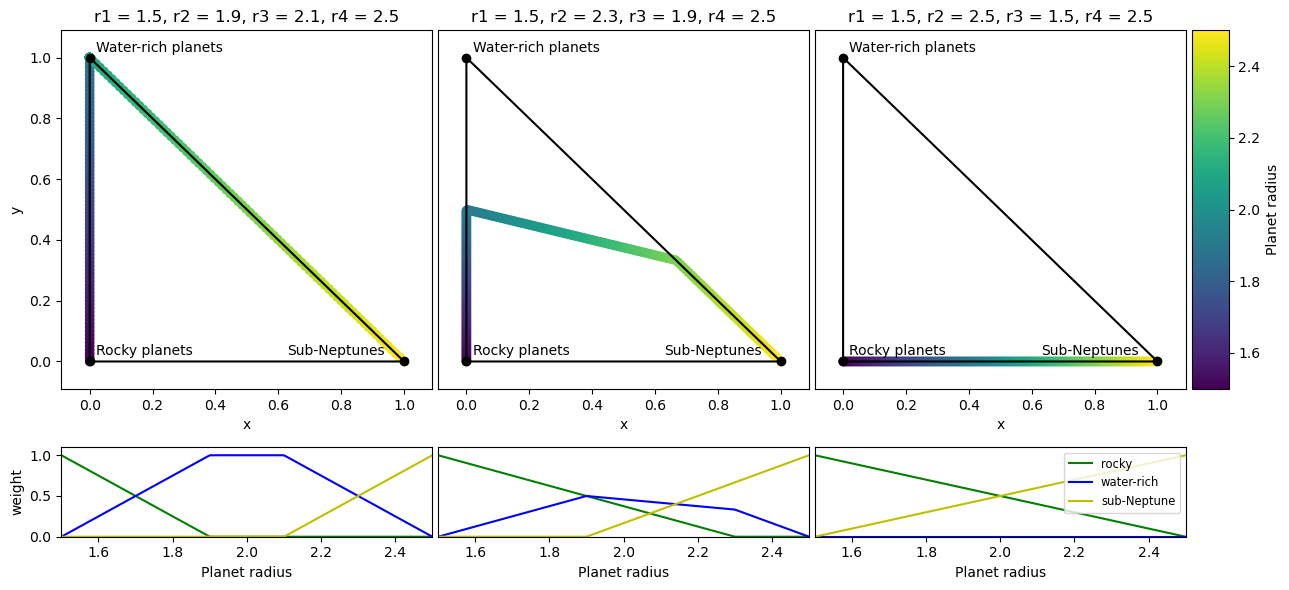

In [76]:
fig, axs = subplots(2, 4, figsize=(13, 6), gridspec_kw={'width_ratios':[1,1,1,0.1], 'height_ratios':[0.8,0.2]})

r1, r4 = 1.5, 2.5
r2r3 = (1.9, 2.1), (2.3, 1.9), (2.5,1.5)
r = linspace(r1, r4, 200)

for ax in axs[0, :-1]:
    ax.plot([0,1,0,0], [0,0,1,0], 'k')
    ax.plot([0,1,0], [0,0,1], 'ok')
    ax.text(0.02, 0.02, 'Rocky planets')
    ax.text(0.02, 1.02, 'Water-rich planets')
    ax.text(0.94, 0.02, 'Sub-Neptunes', ha='right')

for i, (r2, r3) in enumerate(r2r3):
    x, y = map_r_to_xy(r, r1, r2, r3, r4)
    wr,ww,wp = mixture_weights(x, y)
    l = axs[0,i].scatter(x, y, c=r)
    axs[0,i].set_title(f"r1 = {r1}, r2 = {r2}, r3 = {r3}, r4 = {r4}")
    axs[1,i].plot(r, wr, 'g', label='rocky')
    axs[1,i].plot(r, ww, 'b', label='water-rich')
    axs[1,i].plot(r, wp, 'y', label='sub-Neptune')
fig.colorbar(l, label='Planet radius', cax=axs[0, -1])
axs[1,2].legend(fontsize='small', loc='upper right')
setp(axs[:, 1:-1], yticks=[])
setp(axs[0,0], ylabel='y')
setp(axs[1,0], ylabel='weight')
setp(axs[0,:-1], xlabel='x', ylim=(-0.09, 1.09), xlim=(-0.09, 1.09))
setp(axs[1], xlabel='Planet radius', xlim=(r1,r4), ylim=(0, 1.1))
axs[1,3].set_visible(False)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02)

## Mapping of $\omega$ and $\psi$ to $r_2$ and $r_3$

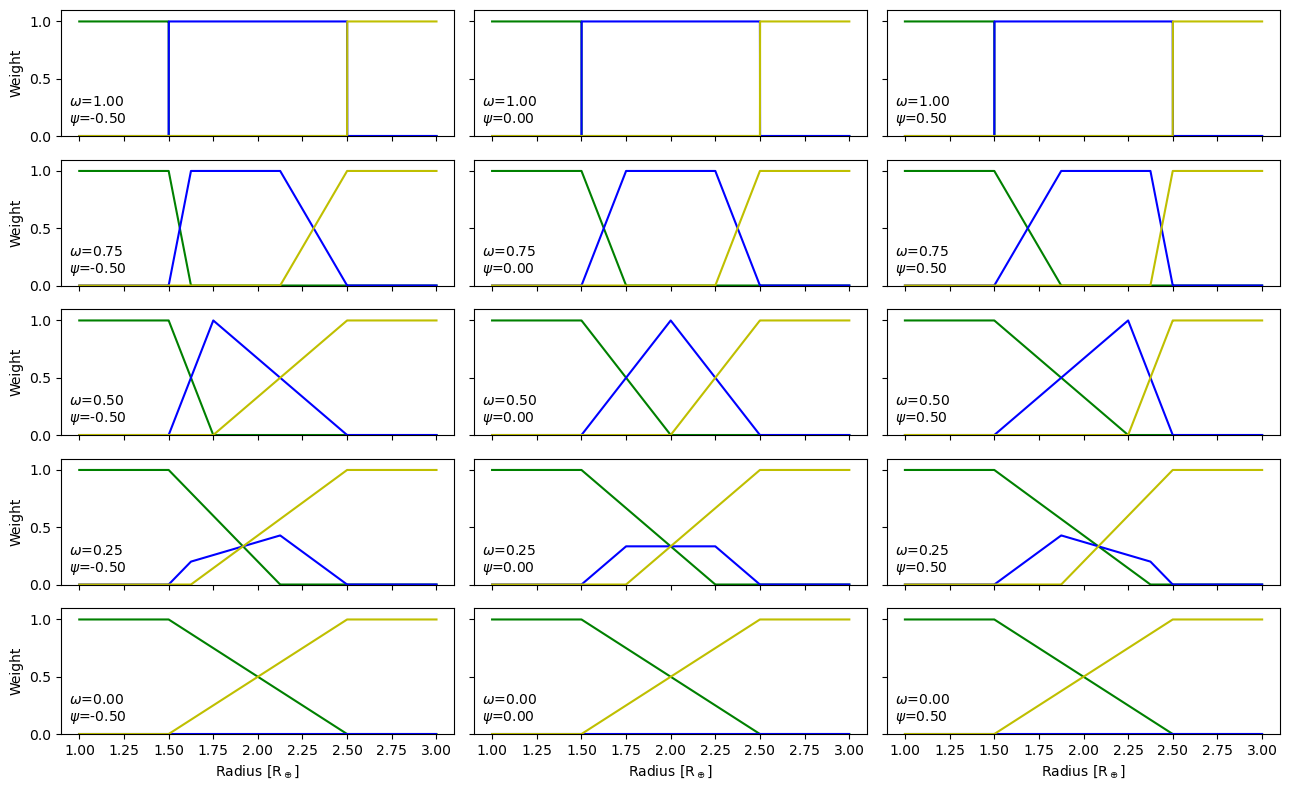

In [4]:
ws = linspace(1.0, 0, 5)
ps = array([-0.5, 0.0, 0.5])

pv = ones(10)
pv[:4] = 1.5, 2.5, 0.75, -0.5

fig, axs = subplots(ws.size, ps.size, figsize=(13, 8), sharex='all', sharey='all')
for iw, w in enumerate(ws):
    pv[2] = w
    for ip, p in enumerate(ps):
        pv[3] = p
        r1, r2, r3, r4 = map_pv(pv)[:4]
        r = array([1.0, r1, r2, r3, r4, 3.0])
        r = concatenate([r, r+1e-3, r-1e-3])
        r.sort()
        x, y = map_r_to_xy(r, r1, r2, r3, r4)
        wr, ww, wp = mixture_weights(x, y)
        axs[iw, ip].plot(r, wr, 'g')
        axs[iw, ip].plot(r, ww, 'b')
        axs[iw, ip].plot(r, wp, 'y')
        axs[iw, ip].text(0.02, 0.1, f'$\omega$={w:.2f}\n$\psi$={p:.2f}', transform=axs[iw, ip].transAxes)

setp(axs, ylim=(0,1.1))
setp(axs[:, 0], ylabel='Weight')
setp(axs[-1], xlabel='Radius [R$_\oplus$]')
fig.tight_layout()

---
<center>
   &copy; 2023 Hannu Parviainen
</center>